In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [11]:
## Example

In [12]:
def plot_s5w_srst_data(s5w_file, srst_file):
    # read S5W and SRST CSV files - change head to phead (for some reason, "head" causes plot error)
    s5w_0 = pd.read_csv (s5w_file)
    s5w = s5w_0.rename({'head': 'phead'}, axis='columns')
    srst_0 = pd.read_csv (srst_file, index_col=0)
    srst_1 = srst_0.rename({'phd': 'phead', 'cyl': 'lws'}, axis='columns')
    srst = srst_1.rename({'servocyl': 'cyl'}, axis='columns')
    srst.to_csv('renamed_srst.csv')
    srst.sort_values(["phead", "cyl"], axis=0, ascending=True, inplace=True)
    srst_sorted_df = srst.reset_index(drop=True)
    # print(srst_sorted_df)

    srst_sorted_df.to_csv('srst_sorted_df.csv', index=False)
    # make S5W dataframe then sort
    s5w_raw_servo_df = s5w[['cyl', 'phead']].copy()
    s5w_raw_servo_df.sort_values(["phead", "cyl"], axis=0, ascending=True, inplace=True)
    # s5w_raw_servo_df.csv for not found comparison
    s5w_raw_servo_df = s5w_raw_servo_df.reset_index(drop=True)
    s5w_raw_servo_df.to_csv('s5w_raw_servo_df.csv')
    # hddsn = s5w['hddsn'][0]
    pd.options.display.max_rows = 99
    # print(s5w)
    # s5w_raw_servo_df.plot.scatter(x='cyl', y='phead', c='Blue')

    # srst.sort_values(["phead", "cyl"], axis=0, ascending=True, inplace=True)
    # print(type(srst))
    # print(srst)

    # make intermedia SRST dataframe to get flags and error code
    partial_srst_df = srst_sorted_df[['cyl', 'phead', 'flags', 'errorcode']].copy()
    # df2.plot.scatter(x='cyl', y='phead', c='Red')

    # make srst dataframe then sort
    srst_raw_servo_df = pd.DataFrame(partial_srst_df, columns=['cyl', 'phead'])
    srst_raw_servo_df.sort_values(["phead", "cyl"], axis=0, ascending=True, inplace=True)
    # srst_raw_servo_df for not found comparison
    srst_raw_servo_df.to_csv('srst_raw_servo_df.csv')

    # make srst individual dataframe
    srst_cyl_df = srst_sorted_df[['cyl']].copy()
    srst_phd_df = srst_sorted_df[['phead']].copy()
    srst_flg_df = srst_sorted_df[['flags']].copy()
    srst_errorcode_df = partial_srst_df[['errorcode']].copy()

    # make srst individual list
    srst_cyl_list = srst_cyl_df.values.tolist()
    srst_phd_list = srst_phd_df.values.tolist()
    srst_flg_list = srst_flg_df.values.tolist()
    srst_errorcode_list = srst_errorcode_df.values.tolist()

    # make TA type corresponding head value list
    newhd = []
    for indx, flg in enumerate(srst_flg_list):
        hd_offset = 0.0
        if (flg[0] == 50):
            hd_offset = round(srst_phd_list[indx][0] + 0.2 + srst_errorcode_list[indx][0] * 0.2, 1)
        elif (flg[0] == 40):
            if (srst_errorcode_list[indx][0] == 4):
                hd_offset = round(srst_phd_list[indx][0] + 0.2 + srst_errorcode_list[indx][0] * 0.2 - 0.1, 1)
            else:
                hd_offset = round(srst_phd_list[indx][0] + 0.2 + srst_errorcode_list[indx][0] * 0.2, 1)
        newItem = [srst_cyl_list[indx][0], hd_offset]
        newhd.append(newItem)

    # make SRST TA type corresponding head value dataframe
    srst_raw_servo_taPhd_df = pd.DataFrame(newhd, columns=['cyl', 'phead'])
    # srst_raw_servo_taPhd_df.to_csv('srst_raw_servo_taPhd_df.csv')

    # concatenate SRST and S5W dataframe 
    srst_s5w_ta_df_list = [srst_raw_servo_taPhd_df, s5w_raw_servo_df]
    srst_s5w_ta_df = pd.concat(srst_s5w_ta_df_list)
    srst_s5w_ta_df = srst_s5w_ta_df.reset_index(drop=True)
    # srst_s5w_ta_df.to_csv('srst_s5w_df.csv')

    # make head value one decimal point
    head_int, head_decimal = divmod(srst_s5w_ta_df['phead'], 1)
    # print(d)
    head_floating = np.round(head_decimal, 1)

    # make TA type base on head value
    ta_txt = []
    for item in head_floating:
        if item == 0: ta_txt.append('S5W')
        elif item == 0.2: ta_txt.append('DLM')
        elif item == 0.4: ta_txt.append('TA1')
        elif item == 0.6: ta_txt.append('TA2')
        elif item == 0.8: ta_txt.append('TA3')
        elif item == 0.9: ta_txt.append('TA4')

    # new dataframe include TA type    
    srst_s5w_ta_df['TA'] = ta_txt
    # print(srst_s5w_ta_df)
    # ax = df5.plot.scatter(x='cyl', y='phead', c='TA', cmap='Greens_r', s=0.5)
    # ax = df5.plot.scatter(x='cyl', y='phead', c='Blue', s=0.5)
    srst_ta_df = srst_s5w_ta_df[srst_s5w_ta_df['TA'] != 'S5W']
    # srst_ta_df for not found comparison
    srst_ta_df.to_csv('srst_ta_df.csv')
    srst_s5w_ta_df.to_csv('srst_s5w_ta_df.csv')
    # print(srst_s5w_ta_df)
    plot_ta_sites(srst_s5w_ta_df, "S5W and SRST TA Sites", "Raw Servo Cylinder")


In [13]:
def plot_ta_sites(ta_site_list, title, x_axis):
    plt.figure(figsize=(9, 5))
    groups = ta_site_list.groupby('TA')
    for name, group in groups:
    # print('name: ', name, '\n')
        if name == 'S5W': 
            color = 'black'; marker = 's'
        # print('name: ', name, group.cyl, group.phead)
        elif name == 'DLM': color = 'green'; marker = '^'
        elif name == 'TA1': color = 'blue'; marker = '^'
        elif name == 'TA2': color = 'magenta'; marker = 'o'
        elif name == 'TA3': color = 'red'; marker = 'X'
        elif name == 'TA4': color = 'red'; marker = '^'
        plt.plot(group.cyl, group.phead, marker=marker, linestyle='', markersize=0.3, label=name, color=color)

    plt.legend(loc=(1.01,0), fontsize=7)
    ax = plt.gca()

    # Major ticks every 20, minor ticks every 5
    major_ticks_x = np.arange(0,700000,100000)
    minor_ticks_x = np.arange(0,700000,10000)
    major_ticks_y = np.arange(0,19,1)
    minor_ticks_y = np.arange(0,18,0.5)

    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    # if you want different settings for the grids:
    ax.grid(which='minor', alpha=1, color='lightgrey', linewidth=0.2)
    ax.grid(which='major', alpha=1, color='darkblue', linewidth=0.1)

    plt.rcParams['figure.dpi'] = 200
    plt.rc('grid', linestyle="-")
    plt.title(file_name + "   " + title)
    plt.xlabel(x_axis)
    plt.ylabel("Physical Head")


In [14]:
def plot_diff_and_lws(srst_file):
    range_cyl = 200            
    s5w_iterator = iter(open("s5w_raw_servo_df.csv"))
    srst_iterator = iter(open("srst_raw_servo_df.csv"))
    srst_ta_type_iterator = iter(open("srst_ta_df.csv"))
    next(s5w_iterator)
    next(srst_iterator)
    next(srst_ta_type_iterator)

    # make S5W TA site list
    s5w_ta_sites = []
    while True:
        try:
            s5w_cyl_hd = next(s5w_iterator)
            s5w_list = s5w_cyl_hd.split(",")
            # print('s5w_list: ', s5w_list)
            s5w_ta_site = [s5w_list[2].strip(), s5w_list[1]]
            s5w_ta_sites.append([s5w_ta_site[0], s5w_ta_site[1]])        
        except StopIteration:
            break
    # print(np.size(s5w_ta_sites), type(s5w_ta_sites))
    # print(s5w_ta_sites)

    # make srst TA site list
    srst_ta_sites = []
    while True:
        try:
            srst_cyl_hd = next(srst_iterator)
            srst_list = srst_cyl_hd.split(",")
            srst_ta_site = [srst_list[2].strip(), srst_list[1]]
            srst_ta_sites.append(srst_ta_site)        
        except StopIteration:
            break
    # print(np.size(srst_ta_sites), type(srst_ta_sites))
    # print(srst_ta_sites) 

    # make srst TA site with type list
    srst_ta_type_sites = []
    while True:
        try:
            srst_cyl_hd = next(srst_ta_type_iterator)
            srst_list = srst_cyl_hd.split(",")
            srst_ta_site = [srst_list[2], srst_list[1], srst_list[3].strip()]
            srst_ta_type_sites.append(srst_ta_site)        
        except StopIteration:
            break
    # print(np.size(srst_ta_type_sites), type(srst_ta_type_sites))
    # print(srst_ta_type_sites) 
    # print(np.size(srst_ta_df), type (srst_ta_df))
    # print(srst_ta_df) 

    # gather found index
    # not_found = []
    found_index = []
    df_index = 0
    # for srst_ta in zip(srst_ta_sites, srst_ta_type_sites):
    for srst_ta in srst_ta_sites:
        # print('srst_ta: ', srst_ta)
        found = False
        for s5w_ta in s5w_ta_sites:
            # print('srst_ta: ', srst_ta, 's5w_ta: ', s5w_ta)
            # if same head, check cyl
            if int(srst_ta[0]) == int(s5w_ta[0]):
                # if cyl within range, mark found
                if (int(srst_ta[1]) <= (int(s5w_ta[1]) + range_cyl)) and (int(srst_ta[1]) >= int(s5w_ta[1])):
                    found = True
                    # # print(srst_ta)
                    # break
                elif int(srst_ta[1]) < int(s5w_ta[1]):
                    break
            elif int(srst_ta[0]) > int(s5w_ta[0]):
                continue
            else:
                break
            if not found:
                # print([srst_ta[1][1], srst_ta[1][0], srst_ta[1][2]])
                # not_found.append([srst_ta[1][1], srst_ta[1][0], srst_ta[1][2]])
                ;
            else:
                # print('df_index: ', df_index)
                found_index.append(df_index)
                break
            # srst_ta_df_copy = srst_ta_df_copy.drop(labels=df_index, axis=0)
        df_index = df_index + 1

    # print('found_index: \n', found_index)    
    found_index_df = pd.DataFrame(found_index, columns=['index'])
    found_index_df.to_csv('found_index_df.csv')
    # print(np.size(not_found))
    # print(found_index)
    # not_found_ta_df = pd.DataFrame(not_found, columns=['cyl', 'phead', 'TA'])

    # drop found TA sites then plot 'not found' TA site
    # print(srst_ta_df)

    srst_ta_df = pd.read_csv ("srst_ta_df.csv")
    srst_ta_df_copy = srst_ta_df.copy()
    srst_ta_df_copy = srst_ta_df_copy.drop(labels=found_index, axis=0)
    pd.options.display.max_rows = 99
    # print(srst_ta_df_copy)
    plot_ta_sites(srst_ta_df_copy, "SRST Found but S5W not Found TA Sites", "Raw Servo Cylinder")






    # get original SRST, drop found by S5W entries and make srst_df_copy_not_found_by_s5w for FA
    srst = pd.read_csv ('renamed_srst.csv')
    srst_df_copy = srst.copy()
    srst_df_copy.sort_values(["phead", "cyl"], axis=0, ascending=True, inplace=True)
    srst_df_copy = srst_df_copy.reset_index(drop=True)
    srst_df_copy = srst_df_copy.drop(labels=found_index, axis=0)
    srst_df_copy.to_csv('srst_df_copy_not_found_by_s5w.csv')

    # get SRST raw Servo TA df, add lws, drop cyl, rename lws to cyl
    srst_lws_df = srst_ta_df_copy
    srst_df_copy_lws_df =srst_df_copy['lws']
    srst_df_copy_lws_df = srst_df_copy_lws_df.reset_index()
    # pd.options.display.max_rows = 99
    # print(srst_df_copy_lws_df)
    # print(srst_lws_df)
    srst_lws_df = srst_lws_df.reset_index()
    srst_lws_df['lws'] = srst_df_copy_lws_df['lws']
    srst_lws_df.drop(['cyl'], axis=1, inplace=True)
    srst_lws_df_1 = srst_lws_df.rename({'lws': 'cyl'}, axis='columns')

    srst_lws_df_2 = pd.DataFrame(srst_lws_df_1, columns=['cyl', 'phead', 'TA'])

    # print(srst_lws_df_2)
    srst_lws_df_2.to_csv('srst_lws_not_found_by_s5w.csv')
    plot_ta_sites(srst_lws_df_2, "SRST Found but S5W not Found TA Sites", "LWS Cylinder")

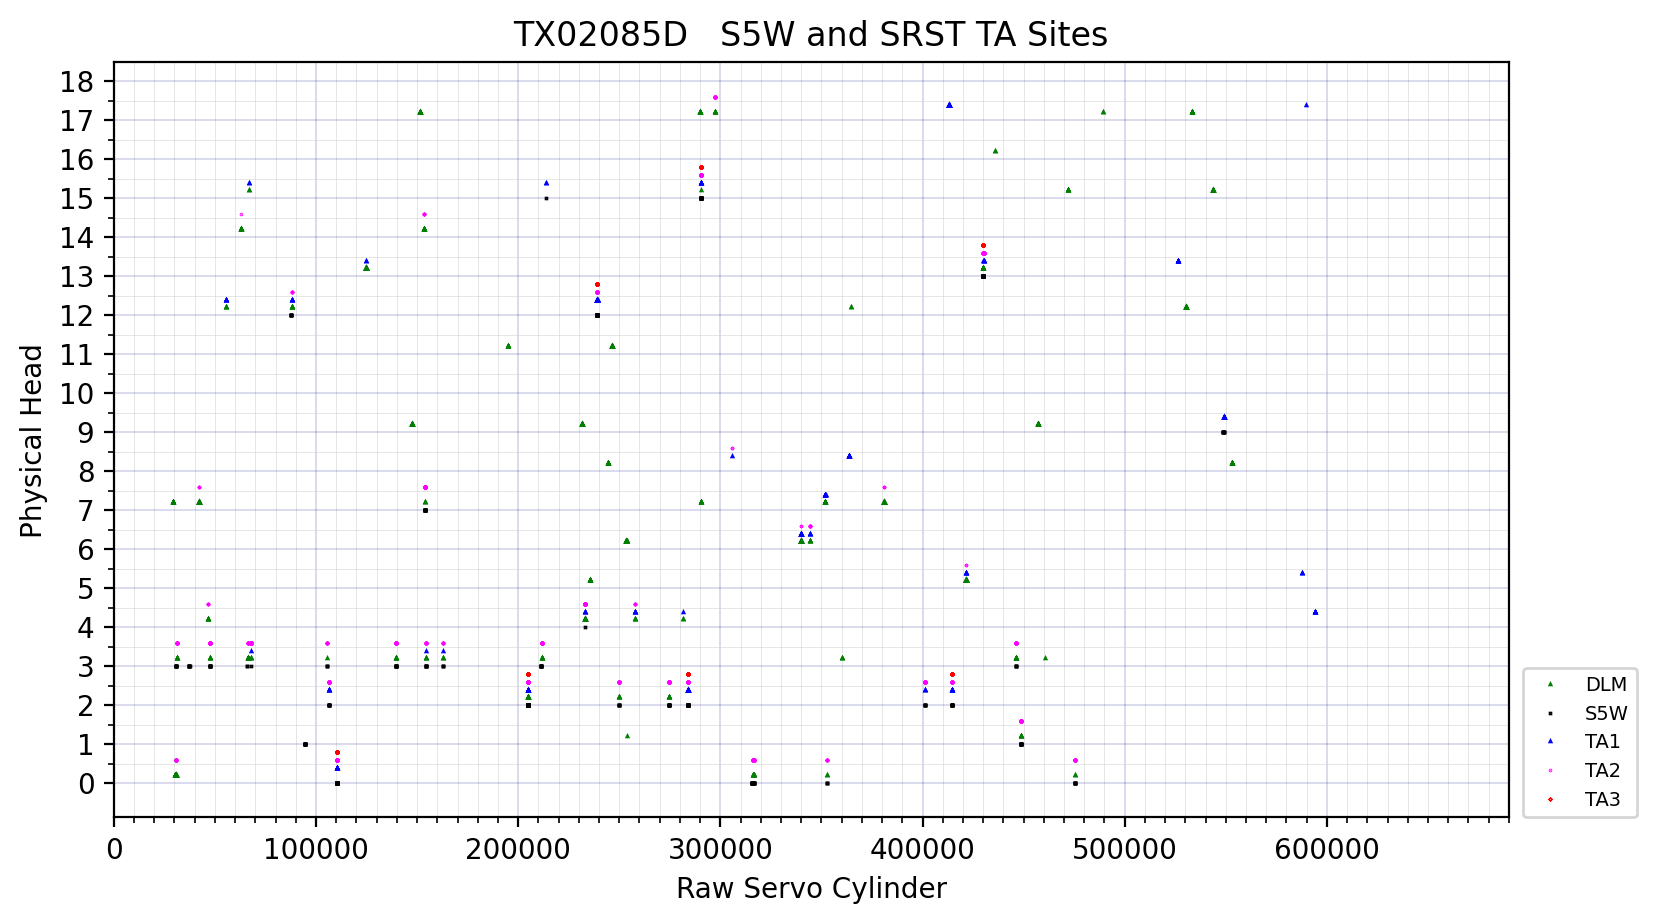

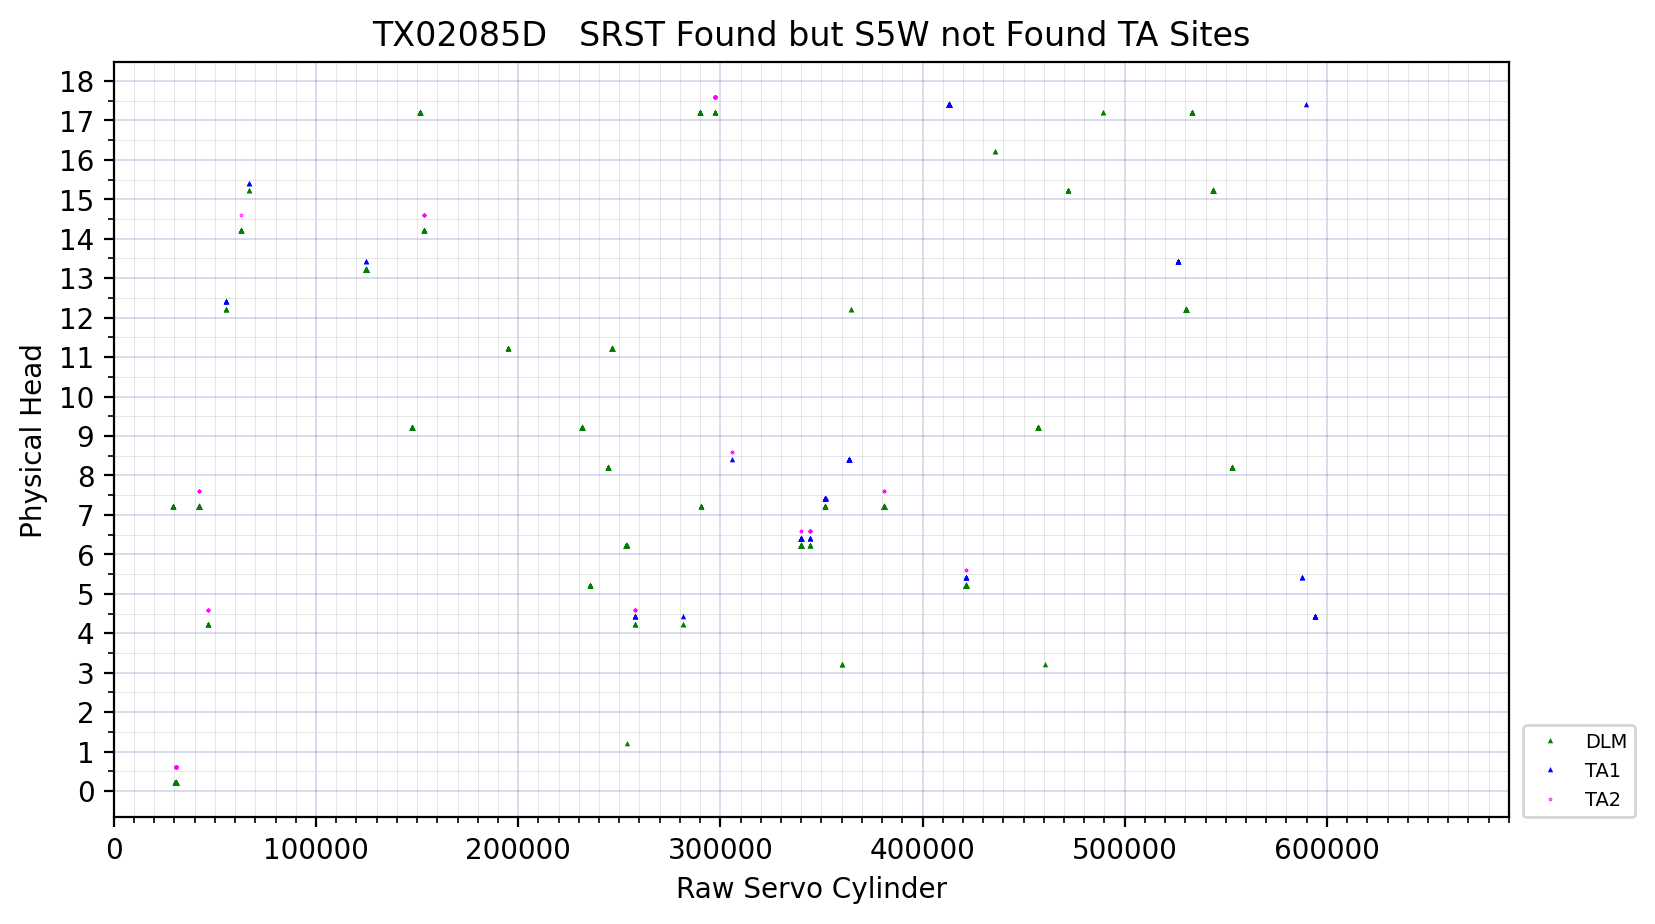

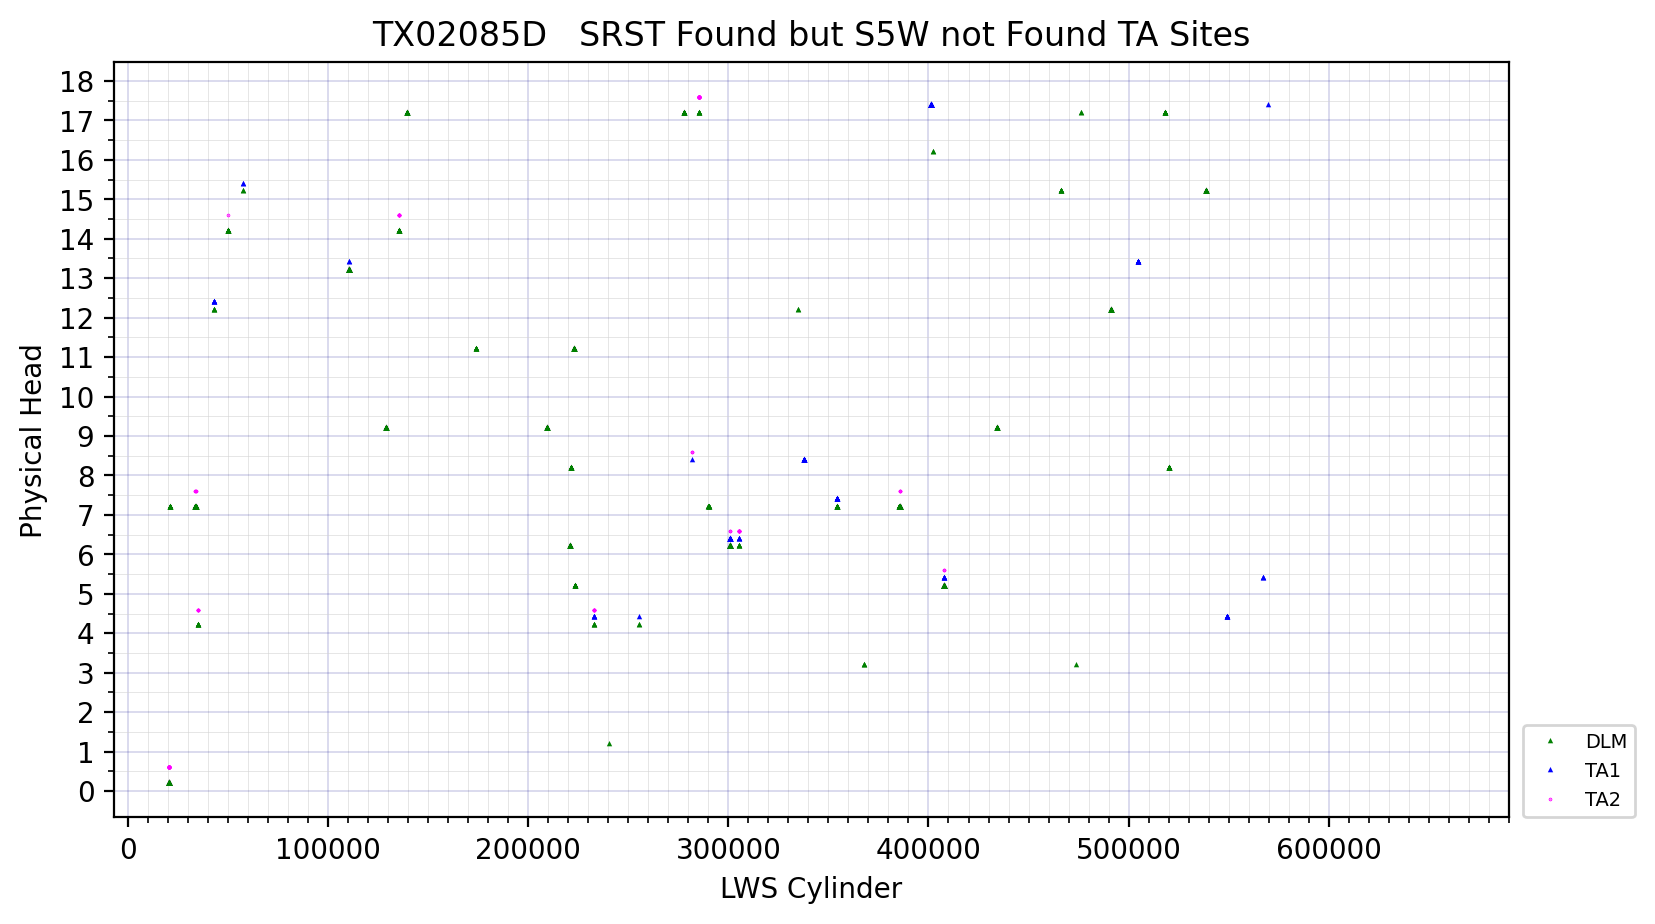

In [20]:
import os
for file in os.listdir("."):
    if file.startswith("TX") and file.endswith("srst.csv"):
        file_name = file[:8]
        
        s5w_file = file_name + '_S5W.csv'
        srst_file = file_name + '_SRST.csv'
        plot_s5w_srst_data(s5w_file, srst_file)
        plot_diff_and_lws(srst_file)


In [22]:
import subprocess

cmd = "ls"
os.system(cmd)
#returned_output = subprocess.check_output(cmd)
#print('Output is:', returned_output.decode("utf-8"))

1

In [28]:
os.system('ping -c 3 google.com')

1

# TA Scan
## SWT VS SRST